# Baltimore City Crime Analysis

Baltimore Crime Data: https://data.baltimorecity.gov/datasets/baltimore::part-1-crime-data-/explore               
Baltimore shape file: https://data.imap.maryland.gov/datasets/maryland::maryland-baltimore-city-neighborhoods/about

   Growing up in the state of Maryland, the excess of crime that occurs in Baltimore covers most news cycles in the local region. As a data scientist, I want to explore trends in crime within the city of Baltimore, and perhaps uncover trends in crime occurance based on inceident based reporting data kept by the city of Baltimore. This notebook details a few ways of bringing the incident based data to life using the folium package, building out interactive marker cluster maps and heat maps.
    
   The crime data source is a frequently updated database of all crime incidents that occur within the city, with attributes for time of day, crime type and location.
    
   This analysis explores the visualization of this data, cultminating with an implementation of heat map that iterates through time. A tool like this could ideally be used to identify problem areas for various types oif crime, understanding the geopgraphical lay out of different crime types across the city


In [1]:
import pandas as pd
import numpy as np
import folium
import datetime as dt
from folium.plugins import HeatMap, MarkerCluster, HeatMapWithTime

First, we read in the data, exploring some of the features. The observations represent specific crime incidents within Baltimore.

In [17]:
crime = pd.read_csv('D:/Part_1_Crime_Data_.csv')
crime.head()

C:\Users\kdmor\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,...,Ethnicity,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents,Shape
0,-76.5719,39.2949,1,2022/06/25 18:00:00+00,4E,3200 E FAYETTE ST,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,224,...,NOT_HISPANIC_OR_LATINO,SOUTHEAST,ELLWOOD PARK/MONUMENT,39.2949,-76.5719,"(39.2949,-76.5719)",NaN,NaN,1,NaN
1,-76.6824,39.3477,2,2022/06/25 20:38:00+00,4E,5300 CUTHBERT AVE,COMMON ASSAULT,NaN,PERSONAL_WEAPONS,633,...,NaN,NORTHWEST,ARLINGTON,39.3477,-76.6824,"(39.3477,-76.6824)",NaN,Northwestern,1,NaN
2,-76.5981,39.2931,3,2022/06/25 14:19:00+00,6F,1400 E FAYETTE ST,LARCENY,NaN,NaN,212,...,NaN,SOUTHEAST,DUNBAR-BROADWAY,39.2931,-76.5981,"(39.2931,-76.5981)",NaN,NaN,1,NaN
3,-76.5939,39.2903,4,2022/06/25 02:00:00+00,6C,100 S BROADWAY,LARCENY,NaN,NaN,212,...,NaN,SOUTHEAST,WASHINGTON HILL,39.2903,-76.5939,"(39.2903,-76.5939)",NaN,NaN,1,NaN
4,-76.6188,39.3033,5,2022/06/25 03:50:00+00,5B,1000 PARK AVE,BURGLARY,NaN,NaN,134,...,NaN,CENTRAL,MID-TOWN BELVEDERE,39.3033,-76.6188,"(39.3033,-76.6188)",NaN,NaN,1,NaN


After some basic data manipulation to format the dates and subset to necessary columns, we discover that the data set is incomplete for 2010 and prior years. Subsequently, we remove those incomplete years form the data. Some more data manipulation is performed to properly format the data for the visualizations.

In [4]:
crime_baltimore = crime.copy()
crime_baltimore = crime_baltimore[['CrimeDateTime','Description', 'District','Neighborhood','Latitude','Longitude']].dropna()
crime_baltimore = crime_baltimore.rename(columns = {'CrimeDateTime': 'DATE', 'Description': 'TYPE', 'District': 'DISTRICT', 'Neighborhood': 'NEIGHBORHOOD','Latitude': 'LAT','Longitude':'LON'})
crime_baltimore['YEAR'] = crime_baltimore['DATE'].str[:4].astype(int)
crime_baltimore = crime_baltimore[crime_baltimore['YEAR'] > 2000]
crime_baltimore['YEAR'].value_counts() # reporting system looks to have changed in 2010

2017    52182
2011    48631
2016    48582
2018    48479
2013    48016
2015    47975
2012    47819
2019    46496
2014    45129
2021    37208
2020    36193
2022    17535
2010       27
2009       15
2008       12
2007       12
2001       10
2002        6
2004        5
2003        4
2006        3
2005        3
Name: YEAR, dtype: int64

In [5]:
crime_baltimore = crime_baltimore[crime_baltimore['YEAR'] > 2010]
crime_baltimore['DATE'] = crime_baltimore['DATE'].str[:10].astype('datetime64[ns]')
crime_baltimore = crime_baltimore.sort_values('DATE').reset_index(drop=True)
crime_baltimore.head()

,DATE,TYPE,DISTRICT,NEIGHBORHOOD,LAT,LON,YEAR
0,2011-01-01,COMMON ASSAULT,CENTRAL,DOWNTOWN,39.2899,-76.6089,2011
1,2011-01-01,AGG. ASSAULT,CENTRAL,DOWNTOWN,39.2900,-76.6153,2011
2,2011-01-01,LARCENY,CENTRAL,DOWNTOWN,39.2885,-76.6070,2011
3,2011-01-01,LARCENY FROM AUTO,NORTHEAST,WOODBOURNE HEIGHTS,39.3589,-76.5909,2011
4,2011-01-01,BURGLARY,SOUTHERN,CHERRY HILL,39.2574,-76.6318,2011


Above displays the general format of the data. Each observation represents a specific incident, descibed by the month it occured in, the crim type, district and neighborhood location, and the coordinates of the offense.

Below, we format the shape file for baltimore city naeighborhoods and render it in a folium map. Features of the map include a tooltip that displays the neighborhood name.

In [6]:
geojson = 'Maryland_Baltimore_City_Neighborhoods.geojson'

In [7]:
start_lat = crime_baltimore['LAT'].mean()
start_lon = crime_baltimore['LON'].mean()

m = folium.Map(
    location = [start_lat, start_lon],
    zoom_start = 12
)

style_function = lambda x: {
    'color' :  'black',
    'opacity' : 0.35,
    'weight' : 3,
    'fillOpacity': 0.1
}

highlight_function = lambda x: {
    'color': 'black',
    'opacity' : 0.9,
    'weight': 4,
    'fillOpacity': 0.4
}

baltimore_neighborhoods = folium.GeoJson(
    geojson,
    name ="Baltimore Neighborhoods",
    style_function = style_function,
    highlight_function = highlight_function,
    
    tooltip = folium.features.GeoJsonTooltip(
        # using fields from the geojson file
        fields=['LABEL'],
        aliases=['Neighborhood: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") # setting style for popup box
      )
).add_to(m)

m.save('baltimore_map.html')

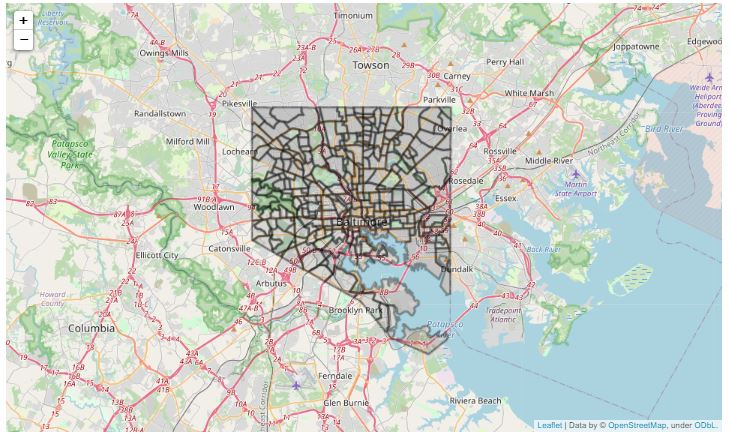

Now, we take a subset of the data for 2011-01, and we plot each crime instance in crime_list on top of the baltimore neighborhood map, showing the specific corrdinates for instances of various crime types in the city. The user may select which crime types to view on the map using the layer control options.

In [18]:
crime_baltimore_2011_01 = crime_baltimore[(crime_baltimore['DATE'].dt.year == 2011) &( crime_baltimore['DATE'].dt.month == 1)]
crime_baltimore_2011_01.head()

,DATE,TYPE,DISTRICT,NEIGHBORHOOD,LAT,LON,YEAR
0,2011-01-01,COMMON ASSAULT,CENTRAL,DOWNTOWN,39.2899,-76.6089,2011
1,2011-01-01,AGG. ASSAULT,CENTRAL,DOWNTOWN,39.2900,-76.6153,2011
2,2011-01-01,LARCENY,CENTRAL,DOWNTOWN,39.2885,-76.6070,2011
3,2011-01-01,LARCENY FROM AUTO,NORTHEAST,WOODBOURNE HEIGHTS,39.3589,-76.5909,2011
4,2011-01-01,BURGLARY,SOUTHERN,CHERRY HILL,39.2574,-76.6318,2011


In [10]:
crime_baltimore['TYPE'].value_counts()

crime_list = ['LARCENY','COMMON ASSAULT','BURGLARY','LARCENY FROM AUTO','AGG. ASSAULT']

In [28]:
m = folium.Map(
    location = [start_lat, start_lon],
    zoom_start = 11
)

style_function = lambda x: {
    'color' :  'black',
    'opacity' : 0.35,
    'weight' : 3,
    'fillOpacity': 0.1
}

baltimore_neighborhoods = folium.GeoJson(
    geojson,
    name ="Baltimore Neighborhoods",
    style_function = style_function,
    tooltip = folium.features.GeoJsonTooltip(
        fields=['LABEL'],
        aliases=['Neighborhood: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") # setting style for popup box
      )
).add_to(m)

types = list(crime_baltimore_2011_01['TYPE'])
popups = ['Type: {}'.format(crime_type) for crime_type in types]

MarkerCluster(
    locations = crime_baltimore_2011_01[['LAT', 'LON']],
    popups = popups,
    name = 'ALL',
).add_to(m)

for t in crime_list:
    crime_data = crime_baltimore_2011_01[crime_baltimore_2011_01['TYPE'] == t]
    popups = ['Type: {}'.format(crime_type) for crime_type in list(crime_data['TYPE'])]
    MarkerCluster(
        locations = crime_data[['LAT', 'LON']],
        name = t,
        popups = popups,
        show = False
    ).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

m.save('baltimore_map_crime.html')

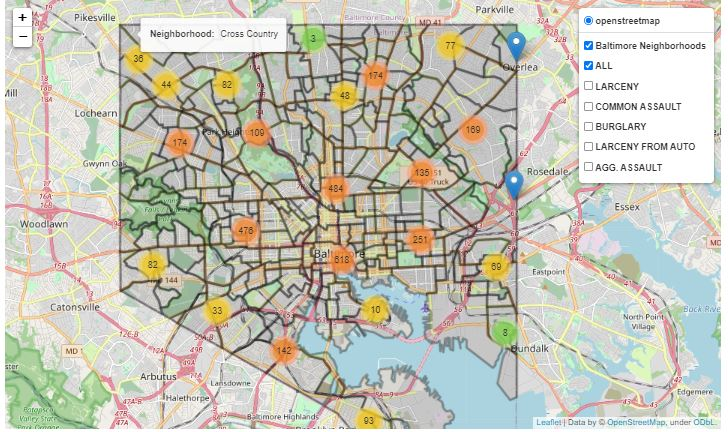

Next, we develop a heat map over time which is able to be filtered to specific crime types to view hot zone for specific crimes from 2011 to present. This always to visually identify troubling areas, and monitor the progression of different crime types in Baltimore over the past decade.

In [30]:
crime_baltimore_month = crime_baltimore.copy()
crime_baltimore_month['DATE'] = crime_baltimore_month['DATE'].dt.to_period('m')
crime_baltimore_month = crime_baltimore_month.set_index('DATE')
crime_baltimore_month.head()

,TYPE,DISTRICT,NEIGHBORHOOD,LAT,LON,YEAR
DATE,,,,,,
2011-01,COMMON ASSAULT,CENTRAL,DOWNTOWN,39.2899,-76.6089,2011
2011-01,AGG. ASSAULT,CENTRAL,DOWNTOWN,39.2900,-76.6153,2011
2011-01,LARCENY,CENTRAL,DOWNTOWN,39.2885,-76.6070,2011
2011-01,LARCENY FROM AUTO,NORTHEAST,WOODBOURNE HEIGHTS,39.3589,-76.5909,2011
2011-01,BURGLARY,SOUTHERN,CHERRY HILL,39.2574,-76.6318,2011


In [31]:
def create_list(month):
    df_month_list.append(
        crime_subset.loc[
            crime_subset.index == month, 
            ['LAT','LON']].groupby(['LAT','LON']).sum().reset_index().values.tolist()
    )

In [32]:
from jinja2 import Template
from folium.map import Layer

folium plugnis documentation: https://python-visualization.github.io/folium/plugins.html

Class HeatMapWithTimeAdditional source: https://github.com/python-visualization/folium/issues/1062

I was able to achieve the folowing heat map iteration with time and multiple layers thanks to the above sources.

In [34]:
class HeatMapWithTimeAdditional(Layer):
    _template = Template("""
        {% macro script(this, kwargs) %}
            var {{this.get_name()}} = new TDHeatmap({{ this.data }},
                {heatmapOptions: {
                    radius: {{this.radius}},
                    minOpacity: {{this.min_opacity}},
                    maxOpacity: {{this.max_opacity}},
                    scaleRadius: {{this.scale_radius}},
                    useLocalExtrema: {{this.use_local_extrema}},
                    defaultWeight: 1,
                    {% if this.gradient %}gradient: {{ this.gradient }}{% endif %}
                }
            }).addTo({{ this._parent.get_name() }});
        {% endmacro %}
    """)

    def __init__(self, data, name=None, radius=15,
                 min_opacity=0, max_opacity=0.6,
                 scale_radius=False, gradient=None, use_local_extrema=False,
                 overlay=True, control=True, show=True):
        super(HeatMapWithTimeAdditional, self).__init__(
            name=name, overlay=overlay, control=control, show=show
        )
        self._name = 'HeatMap'
        self.data = data

        # Heatmap settings.
        self.radius = radius
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity
        self.scale_radius = 'true' if scale_radius else 'false'
        self.use_local_extrema = 'true' if use_local_extrema else 'false'
        self.gradient = gradient

In [35]:
m = folium.Map(
    location = [start_lat, start_lon],
    zoom_start = 11
)

style_function = lambda x: {
    'color' :  'black',
    'opacity' : 0.35,
    'weight' : 3,
    'fillOpacity': 0.1
}

baltimore_neighborhoods = folium.GeoJson(
    geojson,
    name ="Baltimore Neighborhoods",
    style_function = style_function,
    tooltip = folium.features.GeoJsonTooltip(
        fields=['LABEL'],
        aliases=['Neighborhood: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") # setting style for popup box
      )
).add_to(m)

crime_subset = crime_baltimore_month[crime_baltimore_month['TYPE'] == 'COMMON ASSAULT']

df_month_list = []


month = pd.Series(crime_subset.index.unique().sort_values())
month.apply(create_list)

new_list = []
for i in month:
    new_list.append(str(i))

HeatMapWithTime(
    df_month_list,
    name = 'COMMON ASSAULT', 
    auto_play=True,
    max_opacity=0.8,
    index = new_list
).add_to(m)

crimes = ['LARCENY','HOMICIDE', 'AGG. ASSAULT']

for crime in crimes:
    crime_subset = crime_baltimore_month[crime_baltimore_month['TYPE'] == crime]
    
    df_month_list = []
    
    month = pd.Series(crime_baltimore_month.index.unique().sort_values())
    month.apply(create_list)

    new_list = []
    for i in month:
        new_list.append(str(i))
        
    HeatMapWithTimeAdditional(
        df_month_list,
        name = crime,
        min_opacity = 0.05,
        max_opacity = 0.5,
        radius = 20
    ).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

m.save('baltimore_crime_heat_map.html')

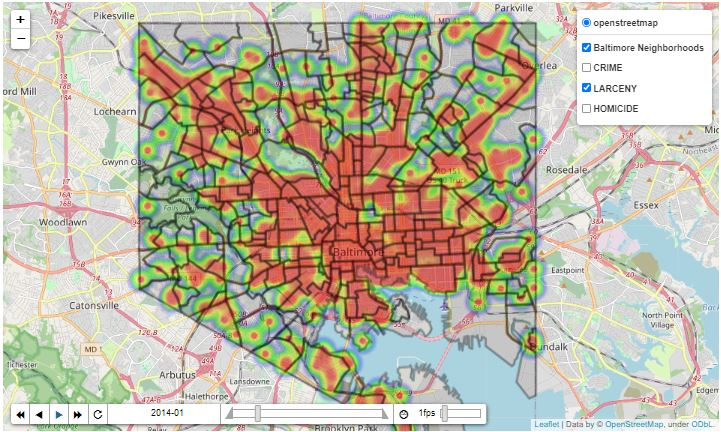